In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
import math

In [2]:
warnings.filterwarnings('ignore')

from itertools import product<br>
import statsmodels.api as sm<br>
from itertools import cycle<br>
import plotly.offline as py<br>
import plotly.graph_objects as go<br>
import plotly.express as px<br>
from plotly.subplots import make_subplots<br>
import math<br>
import datetime as dt<br>
import os

In [3]:
plt.style.use('seaborn-darkgrid')
dolar_data_set = pd.read_csv("NVDA.csv")
group = dolar_data_set[['Close']]
dolar_data_set.head()

print("Veri Seti Büyüklüğü:" , dolar_data_set.shape)

Veri Seti Büyüklüğü: (4279, 7)


In [4]:
prediction_days = 1000

In [5]:
df_train = group[:len(group) - prediction_days].values.reshape(-1, 1)
df_test = group[len(group) - prediction_days:].values.reshape(-1, 1)


In [6]:
chosen_col = 'Close'

In [7]:
scaler_train = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler_train.fit_transform(df_train)

In [8]:
scaler_test = MinMaxScaler(feature_range=(0, 1))
scaled_test = scaler_test.fit_transform(df_test)

In [9]:
def dataset_generator_lstm(dataset, look_back=5):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        window_size_x = dataset[i:(i + look_back), 0]
        dataX.append(window_size_x)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [10]:
trainX, trainY = dataset_generator_lstm(scaled_train)

In [11]:
testX, testY = dataset_generator_lstm(scaled_test)

In [12]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
trainX


array([[[0.02169618],
        [0.02220184],
        [0.0222136 ],
        [0.02141396],
        [0.02159035]],

       [[0.02220184],
        [0.0222136 ],
        [0.02141396],
        [0.02159035],
        [0.02166091]],

       [[0.0222136 ],
        [0.02141396],
        [0.02159035],
        [0.02166091],
        [0.02131988]],

       ...,

       [[0.54388632],
        [0.53432586],
        [0.55573979],
        [0.57905878],
        [0.5334439 ]],

       [[0.53432586],
        [0.55573979],
        [0.57905878],
        [0.5334439 ],
        [0.53760672]],

       [[0.55573979],
        [0.57905878],
        [0.5334439 ],
        [0.53760672],
        [0.49992947]]])

In [13]:
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
print(f"Eğitim Verilerinin Büyüklüğü: {trainX.shape}")
print(f"Test Verilerinin Büyüklüğü: {testX.shape}")
testX

Eğitim Verilerinin Büyüklüğü: (3274, 5, 1)
Test Verilerinin Büyüklüğü: (995, 5, 1)


array([[[0.01747575],
        [0.0180635 ],
        [0.01805523],
        [0.0160353 ],
        [0.01365939]],

       [[0.0180635 ],
        [0.01805523],
        [0.0160353 ],
        [0.01365939],
        [0.01644094]],

       [[0.01805523],
        [0.0160353 ],
        [0.01365939],
        [0.01644094],
        [0.00946223]],

       ...,

       [[0.41392099],
        [0.4050465 ],
        [0.40200005],
        [0.42587503],
        [0.4418027 ]],

       [[0.4050465 ],
        [0.40200005],
        [0.42587503],
        [0.4418027 ],
        [0.43355738]],

       [[0.40200005],
        [0.42587503],
        [0.4418027 ],
        [0.43355738],
        [0.41888804]]])

In [14]:
model = Sequential()
model.add(LSTM(units=128, activation='tanh', return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=64,input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 128)            66560     
                                                                 
 dropout (Dropout)           (None, 5, 128)            0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 116,033
Trainable params: 116,033
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [16]:
checkpoint_path = 'my_best_model.hdf5'

In [17]:
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')

In [18]:
earlystopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

In [19]:
callbacks = [checkpoint, earlystopping]

In [20]:
history = model.fit(trainX, trainY, batch_size=32, epochs=300, verbose=1, shuffle=True, validation_data=(testX, testY),
                    callbacks=callbacks)

Epoch 1/300
 99/103 [===========================>..] - ETA: 0s - loss: 0.0060
Epoch 1: val_loss improved from inf to 0.00115, saving model to my_best_model.hdf5
103/103 [==============================] - 5s 17ms/step - loss: 0.0058 - val_loss: 0.0011
Epoch 2/300
103/103 [==============================] - ETA: 0s - loss: 7.4619e-04
Epoch 2: val_loss did not improve from 0.00115
103/103 [==============================] - 1s 7ms/step - loss: 7.4619e-04 - val_loss: 0.0012
Epoch 3/300
 97/103 [===========================>..] - ETA: 0s - loss: 7.3742e-04
Epoch 3: val_loss improved from 0.00115 to 0.00071, saving model to my_best_model.hdf5
103/103 [==============================] - 1s 7ms/step - loss: 7.4497e-04 - val_loss: 7.0938e-04
Epoch 4/300
100/103 [============================>.] - ETA: 0s - loss: 7.3891e-04
Epoch 4: val_loss did not improve from 0.00071
103/103 [==============================] - 1s 7ms/step - loss: 7.3392e-04 - val_loss: 8.8153e-04
Epoch 5/300
102/103 [==============

Epoch 36/300
102/103 [============================>.] - ETA: 0s - loss: 4.6124e-04
Epoch 36: val_loss did not improve from 0.00054
103/103 [==============================] - 1s 9ms/step - loss: 4.6024e-04 - val_loss: 8.1243e-04
Epoch 37/300
 98/103 [===========================>..] - ETA: 0s - loss: 4.3722e-04
Epoch 37: val_loss did not improve from 0.00054
103/103 [==============================] - 1s 10ms/step - loss: 4.3663e-04 - val_loss: 0.0012
Epoch 38/300
 99/103 [===========================>..] - ETA: 0s - loss: 4.3513e-04
Epoch 38: val_loss did not improve from 0.00054
103/103 [==============================] - 1s 9ms/step - loss: 4.4116e-04 - val_loss: 6.6156e-04
Epoch 39/300
102/103 [============================>.] - ETA: 0s - loss: 5.0966e-04
Epoch 39: val_loss did not improve from 0.00054
103/103 [==============================] - 1s 8ms/step - loss: 5.1172e-04 - val_loss: 5.9525e-04
Epoch 40/300
101/103 [============================>.] - ETA: 0s - loss: 4.4981e-04
Epoch 40

Epoch 71/300
 98/103 [===========================>..] - ETA: 0s - loss: 4.4759e-04
Epoch 71: val_loss improved from 0.00042 to 0.00041, saving model to my_best_model.hdf5
103/103 [==============================] - 1s 8ms/step - loss: 4.4914e-04 - val_loss: 4.0641e-04
Epoch 72/300
102/103 [============================>.] - ETA: 0s - loss: 4.4329e-04
Epoch 72: val_loss improved from 0.00041 to 0.00040, saving model to my_best_model.hdf5
103/103 [==============================] - 1s 8ms/step - loss: 4.4216e-04 - val_loss: 4.0338e-04
Epoch 73/300
 97/103 [===========================>..] - ETA: 0s - loss: 3.9959e-04
Epoch 73: val_loss improved from 0.00040 to 0.00039, saving model to my_best_model.hdf5
103/103 [==============================] - 1s 9ms/step - loss: 3.9595e-04 - val_loss: 3.8785e-04
Epoch 74/300
 97/103 [===========================>..] - ETA: 0s - loss: 4.0208e-04
Epoch 74: val_loss did not improve from 0.00039
103/103 [==============================] - 1s 9ms/step - loss: 4.

Epoch 106/300
 96/103 [==========================>...] - ETA: 0s - loss: 4.4300e-04
Epoch 106: val_loss did not improve from 0.00036
103/103 [==============================] - 1s 8ms/step - loss: 4.4947e-04 - val_loss: 3.9569e-04
Epoch 107/300
 98/103 [===========================>..] - ETA: 0s - loss: 3.9728e-04
Epoch 107: val_loss did not improve from 0.00036
103/103 [==============================] - 1s 8ms/step - loss: 3.9809e-04 - val_loss: 3.7881e-04
Epoch 108/300
 99/103 [===========================>..] - ETA: 0s - loss: 4.1983e-04
Epoch 108: val_loss did not improve from 0.00036
103/103 [==============================] - 1s 8ms/step - loss: 4.2169e-04 - val_loss: 3.7141e-04
Epoch 109/300
102/103 [============================>.] - ETA: 0s - loss: 3.9276e-04
Epoch 109: val_loss did not improve from 0.00036
103/103 [==============================] - 1s 8ms/step - loss: 3.9392e-04 - val_loss: 3.6202e-04
Epoch 110/300
103/103 [==============================] - ETA: 0s - loss: 3.8620e

Epoch 141/300
 98/103 [===========================>..] - ETA: 0s - loss: 4.0832e-04
Epoch 141: val_loss did not improve from 0.00034
103/103 [==============================] - 1s 8ms/step - loss: 3.9818e-04 - val_loss: 5.5492e-04
Epoch 142/300
 96/103 [==========================>...] - ETA: 0s - loss: 4.3372e-04
Epoch 142: val_loss did not improve from 0.00034
103/103 [==============================] - 1s 8ms/step - loss: 4.4319e-04 - val_loss: 5.2593e-04
Epoch 143/300
 96/103 [==========================>...] - ETA: 0s - loss: 3.7783e-04
Epoch 143: val_loss did not improve from 0.00034
103/103 [==============================] - 1s 8ms/step - loss: 3.7084e-04 - val_loss: 4.5355e-04
Epoch 144/300
 99/103 [===========================>..] - ETA: 0s - loss: 3.4659e-04
Epoch 144: val_loss did not improve from 0.00034
103/103 [==============================] - 1s 8ms/step - loss: 3.4943e-04 - val_loss: 6.8626e-04
Epoch 145/300
 97/103 [===========================>..] - ETA: 0s - loss: 4.0627e

Epoch 176/300
101/103 [============================>.] - ETA: 0s - loss: 3.5904e-04
Epoch 176: val_loss did not improve from 0.00033
103/103 [==============================] - 1s 8ms/step - loss: 3.5596e-04 - val_loss: 3.4666e-04
Epoch 177/300
103/103 [==============================] - ETA: 0s - loss: 4.1839e-04
Epoch 177: val_loss did not improve from 0.00033
103/103 [==============================] - 1s 8ms/step - loss: 4.1839e-04 - val_loss: 3.5881e-04
Epoch 178/300
 98/103 [===========================>..] - ETA: 0s - loss: 4.1919e-04
Epoch 178: val_loss did not improve from 0.00033
103/103 [==============================] - 1s 8ms/step - loss: 4.1068e-04 - val_loss: 3.3720e-04
Epoch 179/300
100/103 [============================>.] - ETA: 0s - loss: 3.5376e-04
Epoch 179: val_loss did not improve from 0.00033
103/103 [==============================] - 1s 8ms/step - loss: 3.5513e-04 - val_loss: 3.5755e-04
Epoch 180/300
 96/103 [==========================>...] - ETA: 0s - loss: 3.8776e

 99/103 [===========================>..] - ETA: 0s - loss: 3.6312e-04
Epoch 211: val_loss did not improve from 0.00033
103/103 [==============================] - 1s 8ms/step - loss: 3.6375e-04 - val_loss: 3.4539e-04
Epoch 212/300
100/103 [============================>.] - ETA: 0s - loss: 3.6913e-04
Epoch 212: val_loss did not improve from 0.00033
103/103 [==============================] - 1s 8ms/step - loss: 3.7222e-04 - val_loss: 3.6394e-04
Epoch 213/300
102/103 [============================>.] - ETA: 0s - loss: 3.5834e-04
Epoch 213: val_loss did not improve from 0.00033
103/103 [==============================] - 1s 8ms/step - loss: 3.5980e-04 - val_loss: 7.7281e-04
Epoch 214/300
101/103 [============================>.] - ETA: 0s - loss: 3.6702e-04
Epoch 214: val_loss did not improve from 0.00033
103/103 [==============================] - 1s 9ms/step - loss: 3.6813e-04 - val_loss: 4.0672e-04
Epoch 215/300
102/103 [============================>.] - ETA: 0s - loss: 3.7550e-04
Epoch 215:

103/103 [==============================] - 1s 8ms/step - loss: 3.8485e-04 - val_loss: 0.0013
Epoch 247/300
 98/103 [===========================>..] - ETA: 0s - loss: 4.0128e-04
Epoch 247: val_loss did not improve from 0.00032
103/103 [==============================] - 1s 9ms/step - loss: 3.9687e-04 - val_loss: 3.3027e-04
Epoch 248/300
101/103 [============================>.] - ETA: 0s - loss: 3.1032e-04
Epoch 248: val_loss did not improve from 0.00032
103/103 [==============================] - 1s 11ms/step - loss: 3.0961e-04 - val_loss: 3.4304e-04
Epoch 249/300
102/103 [============================>.] - ETA: 0s - loss: 3.5550e-04
Epoch 249: val_loss did not improve from 0.00032
103/103 [==============================] - 1s 8ms/step - loss: 3.5468e-04 - val_loss: 4.4105e-04
Epoch 250/300
101/103 [============================>.] - ETA: 0s - loss: 3.6590e-04
Epoch 250: val_loss did not improve from 0.00032
103/103 [==============================] - 1s 9ms/step - loss: 3.7549e-04 - val_los

Epoch 282/300
103/103 [==============================] - ETA: 0s - loss: 4.0021e-04
Epoch 282: val_loss did not improve from 0.00032
103/103 [==============================] - 1s 8ms/step - loss: 4.0021e-04 - val_loss: 5.0741e-04
Epoch 283/300
101/103 [============================>.] - ETA: 0s - loss: 3.8008e-04
Epoch 283: val_loss did not improve from 0.00032
103/103 [==============================] - 1s 8ms/step - loss: 3.7878e-04 - val_loss: 3.2977e-04
Epoch 284/300
102/103 [============================>.] - ETA: 0s - loss: 3.8352e-04
Epoch 284: val_loss did not improve from 0.00032
103/103 [==============================] - 1s 8ms/step - loss: 3.8290e-04 - val_loss: 4.0761e-04
Epoch 285/300
 98/103 [===========================>..] - ETA: 0s - loss: 3.8766e-04
Epoch 285: val_loss did not improve from 0.00032
103/103 [==============================] - 1s 8ms/step - loss: 3.8052e-04 - val_loss: 4.7792e-04
Epoch 286/300
 96/103 [==========================>...] - ETA: 0s - loss: 3.3182e

In [21]:
model_from_saved_checkpoint = load_model(checkpoint_path)

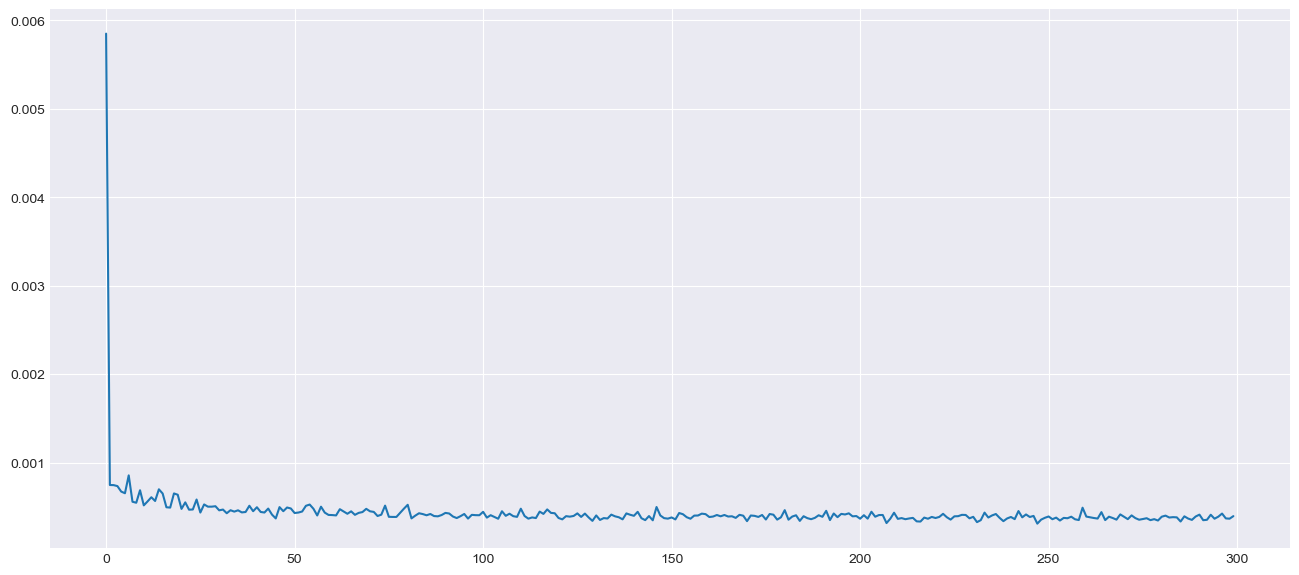

In [22]:
plt.figure(figsize=(16, 7))
plt.plot(history.history['loss'], label='train')

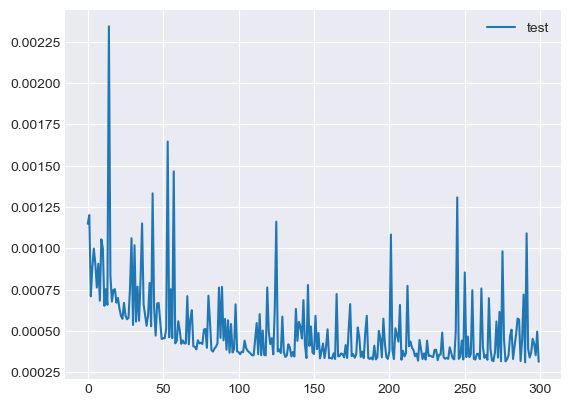

In [23]:
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [24]:
predicted_dolar_price_train_data = model_from_saved_checkpoint.predict(trainX)

103/103 [==============================] - 1s 2ms/step


In [25]:
predicted_dolar_price_train_data = scaler_train.inverse_transform(predicted_dolar_price_train_data.reshape(-1, 1))

In [26]:
train_actual = scaler_train.inverse_transform(trainY.reshape(-1, 1))

In [27]:
plt.figure(figsize=(16, 7))

<Figure size 1600x700 with 0 Axes>

<Figure size 1600x700 with 0 Axes>

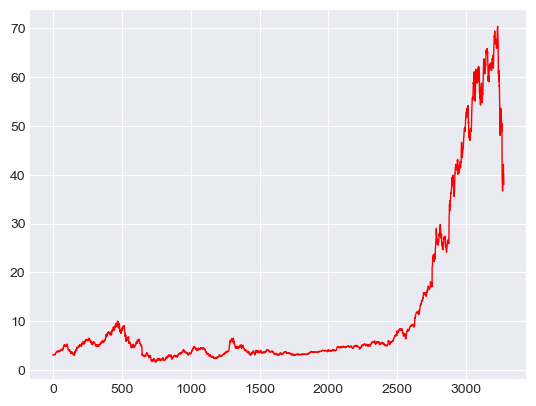

In [28]:
plt.plot(predicted_dolar_price_train_data, 'r', label='Education Estimated Price', linewidth="1")

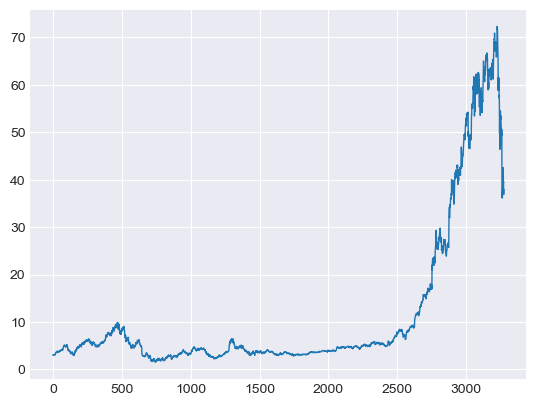

In [29]:
plt.plot(train_actual, label='Real Price', linewidth="1")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


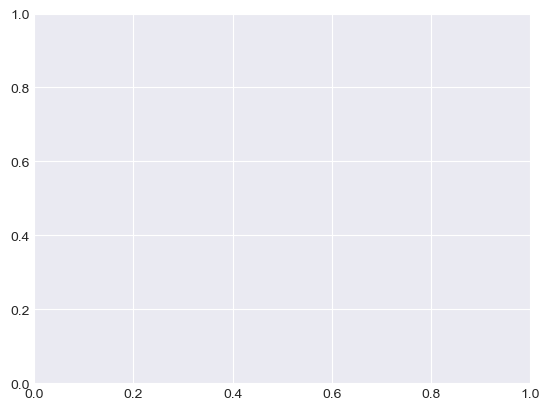

In [30]:
plt.legend()
plt.show()

In [31]:
predicted_dolar_price_test_data = model_from_saved_checkpoint.predict(testX)

32/32 [==============================] - 0s 3ms/step


In [32]:
predicted_dolar_price_test_data = scaler_test.inverse_transform(predicted_dolar_price_test_data.reshape(-1, 1))

In [33]:
test_actual = scaler_test.inverse_transform(testY.reshape(-1, 1))

-------------------------------------------------------

In [34]:
plt.figure(figsize=(16, 7))

<Figure size 1600x700 with 0 Axes>

<Figure size 1600x700 with 0 Axes>

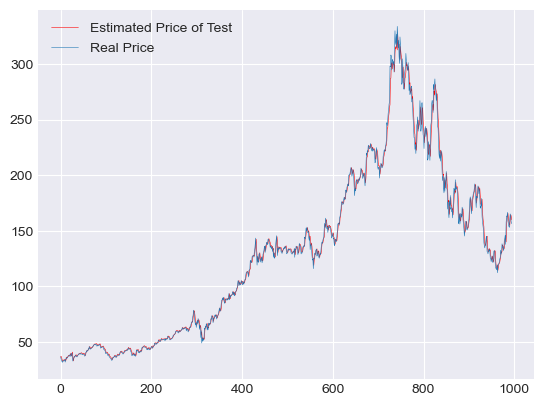

In [35]:
plt.plot(predicted_dolar_price_test_data, 'r', label='Estimated Price of Test', linewidth="0.4")
plt.plot(test_actual, label='Real Price', linewidth="0.4")
plt.legend()
plt.show()

In [36]:
lookback_period = 15

In [37]:
testX_last_5_day = testX[testX.shape[0] - lookback_period:]

In [38]:
predicted_5_days_forecast_price_test_x = []

In [39]:
for i in range(15):
    predicted_forecast_price_test_x = model_from_saved_checkpoint.predict(testX_last_5_day[i:i + 1])
    predicted_forecast_price_test_x = scaler_test.inverse_transform(predicted_forecast_price_test_x.reshape(-1, 1))
    predicted_5_days_forecast_price_test_x.append(predicted_forecast_price_test_x)

1/1 [==============================] - 0s 16ms/step


In [40]:
predicted_5_days_forecast_price_test_x = np.array(predicted_5_days_forecast_price_test_x)

In [41]:
predicted_5_days_forecast_price_test_x = predicted_5_days_forecast_price_test_x.flatten()

In [42]:
predicted_dolar_price_test_data = predicted_dolar_price_test_data.flatten()

In [43]:
predicted_dolar_test_concatenate = np.concatenate(
    (predicted_dolar_price_test_data, predicted_5_days_forecast_price_test_x))

----------------------------------------------------------------------------

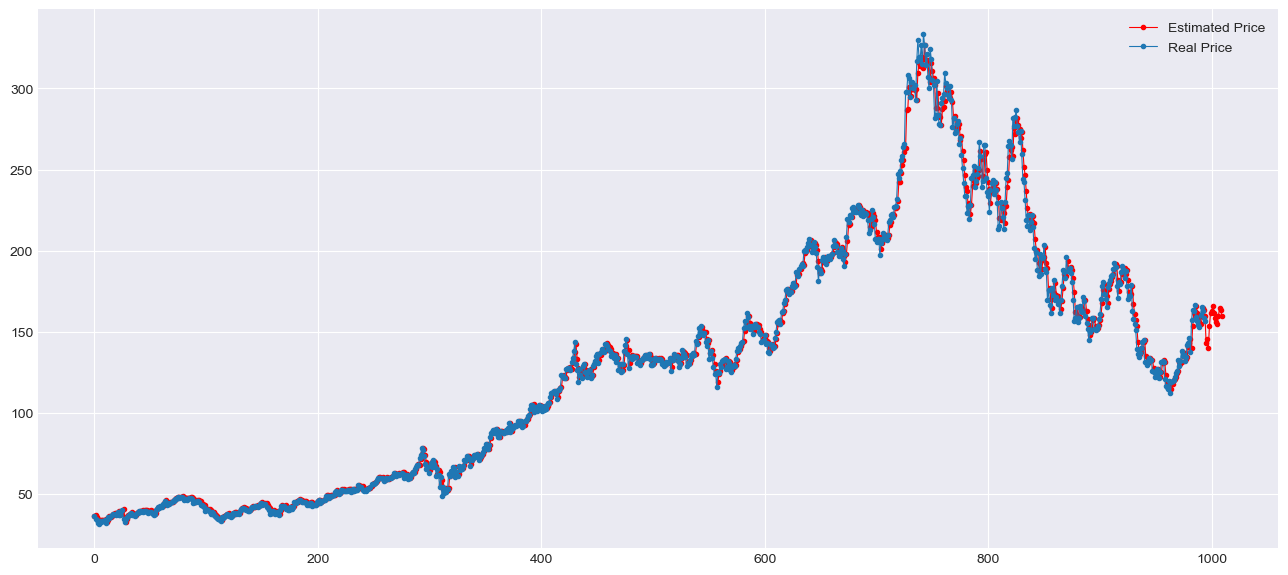

In [44]:
plt.figure(figsize=(16, 7))
plt.plot(predicted_dolar_test_concatenate, 'r', marker='.', label="Estimated Price", linewidth="0.8", alpha=1)
plt.plot(test_actual, label="Real Price", marker='.', linewidth="0.8")
plt.legend()
plt.show()

In [45]:
rmse_lstm_test = math.sqrt(mean_squared_error(test_actual, predicted_dolar_price_test_data))
print('Test RMSE: %.3f' % rmse_lstm_test)

Test RMSE: 5.312


In [46]:
rmse_lstm_train = math.sqrt(mean_squared_error(train_actual, predicted_dolar_price_train_data))

In [47]:
print('Train RMSE: %.3f' % rmse_lstm_train)

Train RMSE: 0.603
